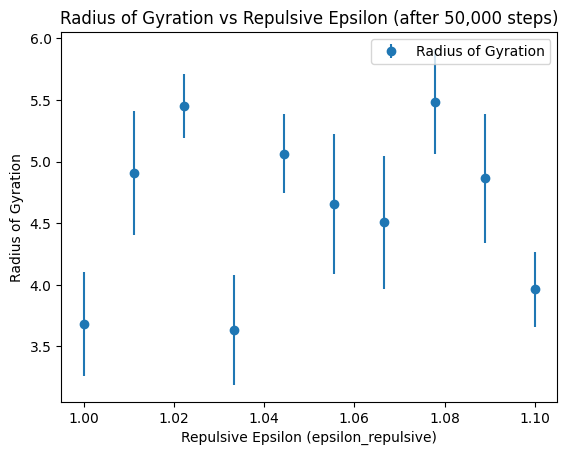

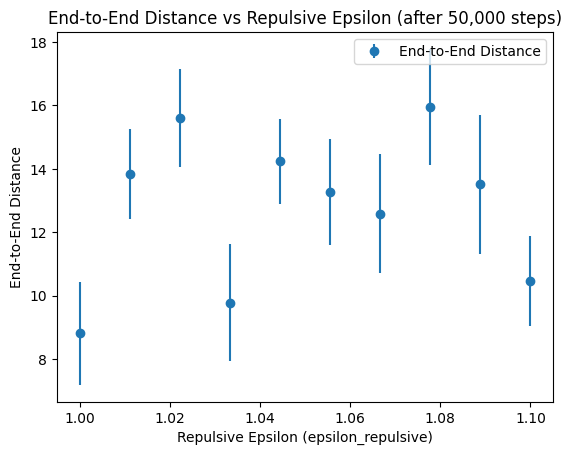

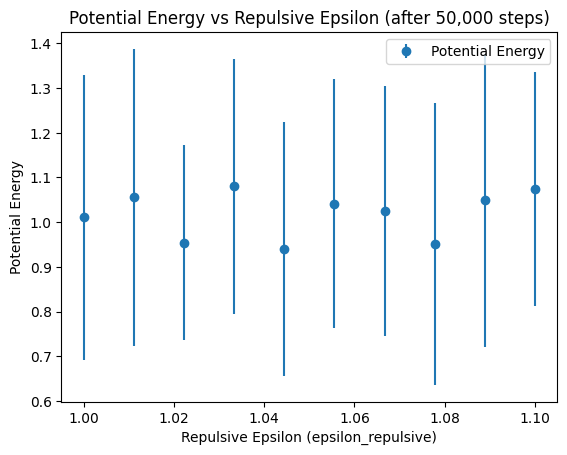

In [1]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from ase import Atoms
from ase.visualize import view

# Set random seed for reproducibility
np.random.seed(42)

# Simulation parameters
dt = 0.01  # Time step
total_steps = 60000  # Number of steps (20,000 in total)
box_size = 100.0  # Size of the cubic box
mass = 1.0  # Particle mass
r0 = 1.0  # Equilibrium bond length
target_temperature = 0.1  # Target temperature (fixed)
rescale_interval = 100  # Steps between velocity rescaling
n_particles = 20  # Number of particles
epsilon_attractive = 0.5  # Depth of attractive LJ potential
sigma = 1.0  # LJ potential parameter
cutoff = 1e-6 * sigma  # Reduce cutoff to limit attraction range
k_B = 1.0  # Boltzmann constant
k = 1.0  # Spring constant (fixed)

# Initialize Positions and Velocities
def initialize_chain(n_particles, box_size, r0):
    positions = np.zeros((n_particles, 3))
    current_position = np.array([box_size / 2, box_size / 2, box_size / 2])
    positions[0] = current_position
    for i in range(1, n_particles):
        direction = np.random.randn(3)
        direction /= np.linalg.norm(direction)
        next_position = current_position + r0 * direction
        positions[i] = next_position % box_size
        current_position = positions[i]
    return positions

def initialize_velocities(n_particles, target_temperature, mass):
    velocities = np.random.normal(0, np.sqrt(k_B * target_temperature / mass), (n_particles, 3))
    velocities -= np.mean(velocities, axis=0)  # Remove net momentum
    return velocities

# Apply Periodic Boundary Conditions
def apply_pbc(position, box_size):
    return position % box_size

# Compute Forces
def minimum_image(displacement, box_size):
    return displacement - box_size * np.round(displacement / box_size)

# Harmonic Forces
def compute_harmonic_forces(positions, k, r0, box_size):
    forces = np.zeros_like(positions)
    for i in range(n_particles - 1):
        displacement = positions[i + 1] - positions[i]
        displacement = minimum_image(displacement, box_size)
        distance = np.linalg.norm(displacement)
        force_magnitude = -k * (distance - r0)
        force = force_magnitude * (displacement / distance)
        forces[i] -= force
        forces[i + 1] += force
    return forces

# Lennard-Jones Forces
def compute_lennard_jones_forces(positions, epsilon, sigma, box_size, interaction_type):
    forces = np.zeros_like(positions)
    for i in range(n_particles - 1):
        for j in range(i + 1, n_particles):
            if interaction_type == 'repulsive' and abs(i - j) == 2:
                epsilon_value = epsilon
            elif interaction_type == 'attractive' and abs(i - j) > 2:
                epsilon_value = epsilon_attractive
            else:
                continue
            displacement = positions[j] - positions[i]
            displacement = minimum_image(displacement, box_size)
            distance = np.linalg.norm(displacement)
            if distance < cutoff:
                force_magnitude = 24 * epsilon_value * ((sigma / distance)**12 - 0.5 * (sigma / distance)**6) / distance
                force = force_magnitude * (displacement / distance)
                forces[i] -= force
                forces[j] += force
    return forces

# Velocity Verlet Integration
def velocity_verlet(positions, velocities, forces, dt, mass, epsilon_repulsive):
    velocities += 0.5 * forces / mass * dt
    positions += velocities * dt
    positions = apply_pbc(positions, box_size)
    new_forces = compute_harmonic_forces(positions, k, r0, box_size) + \
                 compute_lennard_jones_forces(positions, epsilon_repulsive, sigma, box_size, 'repulsive') + \
                 compute_lennard_jones_forces(positions, epsilon_attractive, sigma, box_size, 'attractive')
    velocities += 0.5 * new_forces / mass * dt
    return positions, velocities, new_forces

# Velocity Rescaling Thermostat
def rescale_velocities(velocities, target_temperature, mass):
    kinetic_energy = 0.5 * mass * np.sum(np.linalg.norm(velocities, axis=1)**2)
    current_temperature = (2 / 3) * kinetic_energy / (n_particles * k_B)
    scaling_factor = np.sqrt(target_temperature / current_temperature)
    velocities *= scaling_factor
    return velocities

# Analysis Functions
def calculate_radius_of_gyration(positions):
    center_of_mass = np.mean(positions, axis=0)
    Rg_squared = np.mean(np.sum((positions - center_of_mass)**2, axis=1))
    Rg = np.sqrt(Rg_squared)
    return Rg

def calculate_end_to_end_distance(positions):
    Ree = np.linalg.norm(positions[-1] - positions[0])
    return Ree

# Arrays to store results for different epsilon_repulsive values
epsilon_repulsive_values = np.linspace(1.0, 1.1, 10)
mean_Rg_values = []
std_Rg_values = []
mean_Ree_values = []
std_Ree_values = []
mean_potential_energies = []
std_potential_energies = []

for epsilon_repulsive in epsilon_repulsive_values:
    # Re-initialize positions and velocities for each epsilon_repulsive value
    positions = initialize_chain(n_particles, box_size, r0)
    velocities = initialize_velocities(n_particles, target_temperature, mass)
    forces = compute_harmonic_forces(positions, k, r0, box_size) + \
             compute_lennard_jones_forces(positions, epsilon_repulsive, sigma, box_size, 'repulsive') + \
             compute_lennard_jones_forces(positions, epsilon_attractive, sigma, box_size, 'attractive')

    # Arrays to store properties during each step after 50,000 steps
    Rg_values = []
    Ree_values = []
    potential_energies = []

    # Run simulation loop
    for step in range(total_steps):
        positions, velocities, forces = velocity_verlet(positions, velocities, forces, dt, mass, epsilon_repulsive)
        if step % rescale_interval == 0:
            velocities = rescale_velocities(velocities, target_temperature, mass)

        # Store values only after step 50,000
        if step >= 50000:
            # Compute properties for this step
            Rg = calculate_radius_of_gyration(positions)
            Ree = calculate_end_to_end_distance(positions)

            # Calculate potential energy
            E_harmonic = 0.0
            for i in range(n_particles - 1):
                displacement = positions[i + 1] - positions[i]
                displacement = minimum_image(displacement, box_size)
                distance = np.linalg.norm(displacement)
                E_harmonic += 0.5 * k * (distance - r0)**2

            E_LJ = 0.0
            for i in range(n_particles - 1):
                for j in range(i + 1, n_particles):
                    displacement = positions[j] - positions[i]
                    displacement = minimum_image(displacement, box_size)
                    distance = np.linalg.norm(displacement)
                    if distance < cutoff:
                        if abs(i - j) == 2:
                            epsilon_value = epsilon_repulsive
                        elif abs(i - j) > 2:
                            epsilon_value = epsilon_attractive
                        else:
                            continue
                        E_LJ += 4 * epsilon_value * ((sigma / distance)**12 - (sigma / distance)**6)

            potential_energy = E_harmonic + E_LJ

            # Store values
            Rg_values.append(Rg)
            Ree_values.append(Ree)
            potential_energies.append(potential_energy)

    # Convert lists to NumPy arrays for easier calculations
    Rg_values = np.array(Rg_values)
    Ree_values = np.array(Ree_values)
    potential_energies = np.array(potential_energies)

    # Calculate mean and standard deviation for each property after step 10,000
    mean_Rg_values.append(np.mean(Rg_values))
    std_Rg_values.append(np.std(Rg_values))

    mean_Ree_values.append(np.mean(Ree_values))
    std_Ree_values.append(np.std(Ree_values))

    mean_potential_energies.append(np.mean(potential_energies))
    std_potential_energies.append(np.std(potential_energies))

# Plotting the results with error bars
plt.figure()
plt.errorbar(epsilon_repulsive_values, mean_Rg_values, yerr=std_Rg_values, fmt='o', label='Radius of Gyration')
plt.xlabel('Repulsive Epsilon (epsilon_repulsive)')
plt.ylabel('Radius of Gyration')
plt.title('Radius of Gyration vs Repulsive Epsilon (after 50,000 steps)')
plt.legend()
plt.show()

plt.figure()
plt.errorbar(epsilon_repulsive_values, mean_Ree_values, yerr=std_Ree_values, fmt='o', label='End-to-End Distance')
plt.xlabel('Repulsive Epsilon (epsilon_repulsive)')
plt.ylabel('End-to-End Distance')
plt.title('End-to-End Distance vs Repulsive Epsilon (after 50,000 steps)')
plt.legend()
plt.show()

plt.figure()
plt.errorbar(epsilon_repulsive_values, mean_potential_energies, yerr=std_potential_energies, fmt='o', label='Potential Energy')
plt.xlabel('Repulsive Epsilon (epsilon_repulsive)')
plt.ylabel('Potential Energy')
plt.title('Potential Energy vs Repulsive Epsilon (after 50,000 steps)')
plt.legend()
plt.show()


In [2]:
# Print results for Radius of Gyration
print("Repulsive Epsilon vs Radius of Gyration")
print(f"{'Epsilon_Repulsive':>18} {'Mean Rg':>10} {'Std Rg':>10}")
for epsilon, mean_Rg, std_Rg in zip(epsilon_repulsive_values, mean_Rg_values, std_Rg_values):
    print(f"{epsilon:18.4f} {mean_Rg:10.4f} {std_Rg:10.4f}")

print("\nRepulsive Epsilon vs End-to-End Distance")
print(f"{'Epsilon_Repulsive':>18} {'Mean Ree':>10} {'Std Ree':>10}")
for epsilon, mean_Ree, std_Ree in zip(epsilon_repulsive_values, mean_Ree_values, std_Ree_values):
    print(f"{epsilon:18.4f} {mean_Ree:10.4f} {std_Ree:10.4f}")

print("\nRepulsive Epsilon vs Potential Energy")
print(f"{'Epsilon_Repulsive':>18} {'Mean PE':>10} {'Std PE':>10}")
for epsilon, mean_PE, std_PE in zip(epsilon_repulsive_values, mean_potential_energies, std_potential_energies):
    print(f"{epsilon:18.4f} {mean_PE:10.4f} {std_PE:10.4f}")


Repulsive Epsilon vs Radius of Gyration
 Epsilon_Repulsive    Mean Rg     Std Rg
            1.0000     3.6788     0.4207
            1.0111     4.9079     0.5022
            1.0222     5.4514     0.2626
            1.0333     3.6315     0.4444
            1.0444     5.0635     0.3191
            1.0556     4.6551     0.5691
            1.0667     4.5070     0.5409
            1.0778     5.4872     0.4287
            1.0889     4.8656     0.5243
            1.1000     3.9633     0.3045

Repulsive Epsilon vs End-to-End Distance
 Epsilon_Repulsive   Mean Ree    Std Ree
            1.0000     8.8119     1.6219
            1.0111    13.8341     1.4126
            1.0222    15.5894     1.5360
            1.0333     9.7717     1.8480
            1.0444    14.2334     1.3361
            1.0556    13.2611     1.6619
            1.0667    12.5789     1.8728
            1.0778    15.9413     1.8360
            1.0889    13.5135     2.1916
            1.1000    10.4598     1.4319

Repulsive Epsil

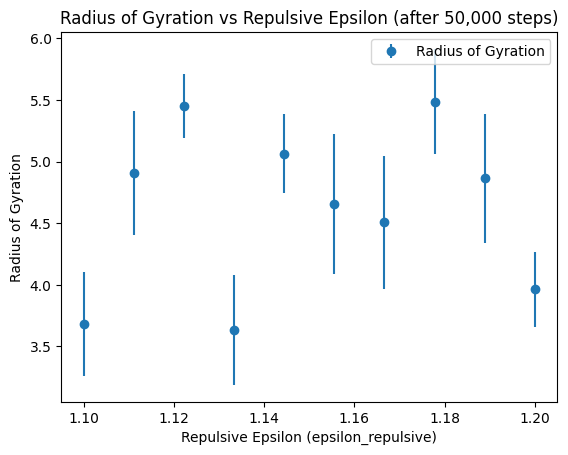

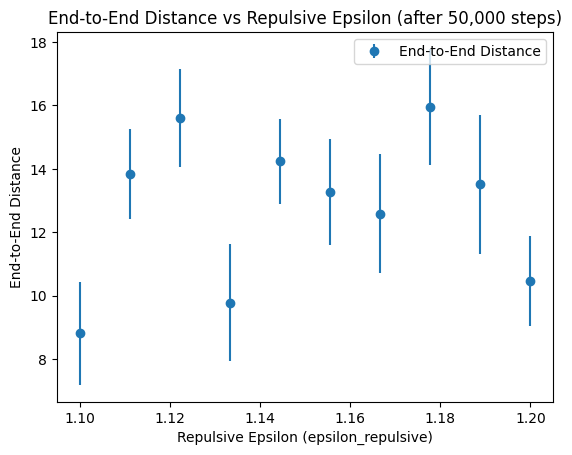

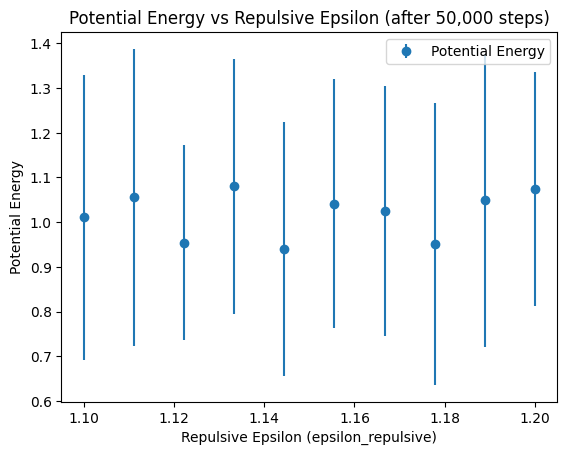

In [3]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from ase import Atoms
from ase.visualize import view

# Set random seed for reproducibility
np.random.seed(42)

# Simulation parameters
dt = 0.01  # Time step
total_steps = 60000  # Number of steps (20,000 in total)
box_size = 100.0  # Size of the cubic box
mass = 1.0  # Particle mass
r0 = 1.0  # Equilibrium bond length
target_temperature = 0.1  # Target temperature (fixed)
rescale_interval = 100  # Steps between velocity rescaling
n_particles = 20  # Number of particles
epsilon_attractive = 0.5  # Depth of attractive LJ potential
sigma = 1.0  # LJ potential parameter
cutoff = 1e-6 * sigma  # Reduce cutoff to limit attraction range
k_B = 1.0  # Boltzmann constant
k = 1.0  # Spring constant (fixed)

# Initialize Positions and Velocities
def initialize_chain(n_particles, box_size, r0):
    positions = np.zeros((n_particles, 3))
    current_position = np.array([box_size / 2, box_size / 2, box_size / 2])
    positions[0] = current_position
    for i in range(1, n_particles):
        direction = np.random.randn(3)
        direction /= np.linalg.norm(direction)
        next_position = current_position + r0 * direction
        positions[i] = next_position % box_size
        current_position = positions[i]
    return positions

def initialize_velocities(n_particles, target_temperature, mass):
    velocities = np.random.normal(0, np.sqrt(k_B * target_temperature / mass), (n_particles, 3))
    velocities -= np.mean(velocities, axis=0)  # Remove net momentum
    return velocities

# Apply Periodic Boundary Conditions
def apply_pbc(position, box_size):
    return position % box_size

# Compute Forces
def minimum_image(displacement, box_size):
    return displacement - box_size * np.round(displacement / box_size)

# Harmonic Forces
def compute_harmonic_forces(positions, k, r0, box_size):
    forces = np.zeros_like(positions)
    for i in range(n_particles - 1):
        displacement = positions[i + 1] - positions[i]
        displacement = minimum_image(displacement, box_size)
        distance = np.linalg.norm(displacement)
        force_magnitude = -k * (distance - r0)
        force = force_magnitude * (displacement / distance)
        forces[i] -= force
        forces[i + 1] += force
    return forces

# Lennard-Jones Forces
def compute_lennard_jones_forces(positions, epsilon, sigma, box_size, interaction_type):
    forces = np.zeros_like(positions)
    for i in range(n_particles - 1):
        for j in range(i + 1, n_particles):
            if interaction_type == 'repulsive' and abs(i - j) == 2:
                epsilon_value = epsilon
            elif interaction_type == 'attractive' and abs(i - j) > 2:
                epsilon_value = epsilon_attractive
            else:
                continue
            displacement = positions[j] - positions[i]
            displacement = minimum_image(displacement, box_size)
            distance = np.linalg.norm(displacement)
            if distance < cutoff:
                force_magnitude = 24 * epsilon_value * ((sigma / distance)**12 - 0.5 * (sigma / distance)**6) / distance
                force = force_magnitude * (displacement / distance)
                forces[i] -= force
                forces[j] += force
    return forces

# Velocity Verlet Integration
def velocity_verlet(positions, velocities, forces, dt, mass, epsilon_repulsive):
    velocities += 0.5 * forces / mass * dt
    positions += velocities * dt
    positions = apply_pbc(positions, box_size)
    new_forces = compute_harmonic_forces(positions, k, r0, box_size) + \
                 compute_lennard_jones_forces(positions, epsilon_repulsive, sigma, box_size, 'repulsive') + \
                 compute_lennard_jones_forces(positions, epsilon_attractive, sigma, box_size, 'attractive')
    velocities += 0.5 * new_forces / mass * dt
    return positions, velocities, new_forces

# Velocity Rescaling Thermostat
def rescale_velocities(velocities, target_temperature, mass):
    kinetic_energy = 0.5 * mass * np.sum(np.linalg.norm(velocities, axis=1)**2)
    current_temperature = (2 / 3) * kinetic_energy / (n_particles * k_B)
    scaling_factor = np.sqrt(target_temperature / current_temperature)
    velocities *= scaling_factor
    return velocities

# Analysis Functions
def calculate_radius_of_gyration(positions):
    center_of_mass = np.mean(positions, axis=0)
    Rg_squared = np.mean(np.sum((positions - center_of_mass)**2, axis=1))
    Rg = np.sqrt(Rg_squared)
    return Rg

def calculate_end_to_end_distance(positions):
    Ree = np.linalg.norm(positions[-1] - positions[0])
    return Ree

# Arrays to store results for different epsilon_repulsive values
epsilon_repulsive_values = np.linspace(1.1, 1.2, 10)
mean_Rg_values = []
std_Rg_values = []
mean_Ree_values = []
std_Ree_values = []
mean_potential_energies = []
std_potential_energies = []

for epsilon_repulsive in epsilon_repulsive_values:
    # Re-initialize positions and velocities for each epsilon_repulsive value
    positions = initialize_chain(n_particles, box_size, r0)
    velocities = initialize_velocities(n_particles, target_temperature, mass)
    forces = compute_harmonic_forces(positions, k, r0, box_size) + \
             compute_lennard_jones_forces(positions, epsilon_repulsive, sigma, box_size, 'repulsive') + \
             compute_lennard_jones_forces(positions, epsilon_attractive, sigma, box_size, 'attractive')

    # Arrays to store properties during each step after 50,000 steps
    Rg_values = []
    Ree_values = []
    potential_energies = []

    # Run simulation loop
    for step in range(total_steps):
        positions, velocities, forces = velocity_verlet(positions, velocities, forces, dt, mass, epsilon_repulsive)
        if step % rescale_interval == 0:
            velocities = rescale_velocities(velocities, target_temperature, mass)

        # Store values only after step 50,000
        if step >= 50000:
            # Compute properties for this step
            Rg = calculate_radius_of_gyration(positions)
            Ree = calculate_end_to_end_distance(positions)

            # Calculate potential energy
            E_harmonic = 0.0
            for i in range(n_particles - 1):
                displacement = positions[i + 1] - positions[i]
                displacement = minimum_image(displacement, box_size)
                distance = np.linalg.norm(displacement)
                E_harmonic += 0.5 * k * (distance - r0)**2

            E_LJ = 0.0
            for i in range(n_particles - 1):
                for j in range(i + 1, n_particles):
                    displacement = positions[j] - positions[i]
                    displacement = minimum_image(displacement, box_size)
                    distance = np.linalg.norm(displacement)
                    if distance < cutoff:
                        if abs(i - j) == 2:
                            epsilon_value = epsilon_repulsive
                        elif abs(i - j) > 2:
                            epsilon_value = epsilon_attractive
                        else:
                            continue
                        E_LJ += 4 * epsilon_value * ((sigma / distance)**12 - (sigma / distance)**6)

            potential_energy = E_harmonic + E_LJ

            # Store values
            Rg_values.append(Rg)
            Ree_values.append(Ree)
            potential_energies.append(potential_energy)

    # Convert lists to NumPy arrays for easier calculations
    Rg_values = np.array(Rg_values)
    Ree_values = np.array(Ree_values)
    potential_energies = np.array(potential_energies)

    # Calculate mean and standard deviation for each property after step 10,000
    mean_Rg_values.append(np.mean(Rg_values))
    std_Rg_values.append(np.std(Rg_values))

    mean_Ree_values.append(np.mean(Ree_values))
    std_Ree_values.append(np.std(Ree_values))

    mean_potential_energies.append(np.mean(potential_energies))
    std_potential_energies.append(np.std(potential_energies))

# Plotting the results with error bars
plt.figure()
plt.errorbar(epsilon_repulsive_values, mean_Rg_values, yerr=std_Rg_values, fmt='o', label='Radius of Gyration')
plt.xlabel('Repulsive Epsilon (epsilon_repulsive)')
plt.ylabel('Radius of Gyration')
plt.title('Radius of Gyration vs Repulsive Epsilon (after 50,000 steps)')
plt.legend()
plt.show()

plt.figure()
plt.errorbar(epsilon_repulsive_values, mean_Ree_values, yerr=std_Ree_values, fmt='o', label='End-to-End Distance')
plt.xlabel('Repulsive Epsilon (epsilon_repulsive)')
plt.ylabel('End-to-End Distance')
plt.title('End-to-End Distance vs Repulsive Epsilon (after 50,000 steps)')
plt.legend()
plt.show()

plt.figure()
plt.errorbar(epsilon_repulsive_values, mean_potential_energies, yerr=std_potential_energies, fmt='o', label='Potential Energy')
plt.xlabel('Repulsive Epsilon (epsilon_repulsive)')
plt.ylabel('Potential Energy')
plt.title('Potential Energy vs Repulsive Epsilon (after 50,000 steps)')
plt.legend()
plt.show()


In [4]:
# Print results for Radius of Gyration
print("Repulsive Epsilon vs Radius of Gyration")
print(f"{'Epsilon_Repulsive':>18} {'Mean Rg':>10} {'Std Rg':>10}")
for epsilon, mean_Rg, std_Rg in zip(epsilon_repulsive_values, mean_Rg_values, std_Rg_values):
    print(f"{epsilon:18.4f} {mean_Rg:10.4f} {std_Rg:10.4f}")

print("\nRepulsive Epsilon vs End-to-End Distance")
print(f"{'Epsilon_Repulsive':>18} {'Mean Ree':>10} {'Std Ree':>10}")
for epsilon, mean_Ree, std_Ree in zip(epsilon_repulsive_values, mean_Ree_values, std_Ree_values):
    print(f"{epsilon:18.4f} {mean_Ree:10.4f} {std_Ree:10.4f}")

print("\nRepulsive Epsilon vs Potential Energy")
print(f"{'Epsilon_Repulsive':>18} {'Mean PE':>10} {'Std PE':>10}")
for epsilon, mean_PE, std_PE in zip(epsilon_repulsive_values, mean_potential_energies, std_potential_energies):
    print(f"{epsilon:18.4f} {mean_PE:10.4f} {std_PE:10.4f}")


Repulsive Epsilon vs Radius of Gyration
 Epsilon_Repulsive    Mean Rg     Std Rg
            1.1000     3.6788     0.4207
            1.1111     4.9079     0.5022
            1.1222     5.4514     0.2626
            1.1333     3.6315     0.4444
            1.1444     5.0635     0.3191
            1.1556     4.6551     0.5691
            1.1667     4.5070     0.5409
            1.1778     5.4872     0.4287
            1.1889     4.8656     0.5243
            1.2000     3.9633     0.3045

Repulsive Epsilon vs End-to-End Distance
 Epsilon_Repulsive   Mean Ree    Std Ree
            1.1000     8.8119     1.6219
            1.1111    13.8341     1.4126
            1.1222    15.5894     1.5360
            1.1333     9.7717     1.8480
            1.1444    14.2334     1.3361
            1.1556    13.2611     1.6619
            1.1667    12.5789     1.8728
            1.1778    15.9413     1.8360
            1.1889    13.5135     2.1916
            1.2000    10.4598     1.4319

Repulsive Epsil

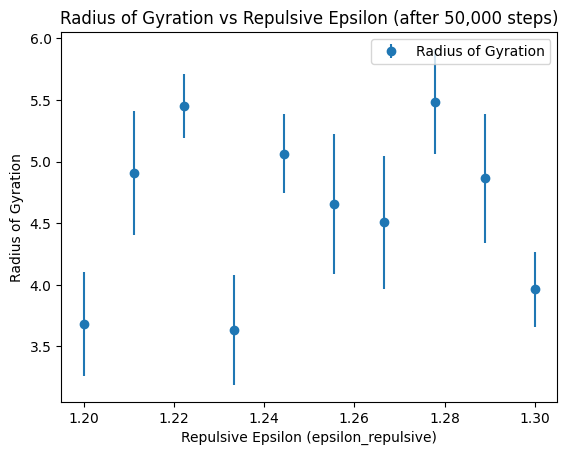

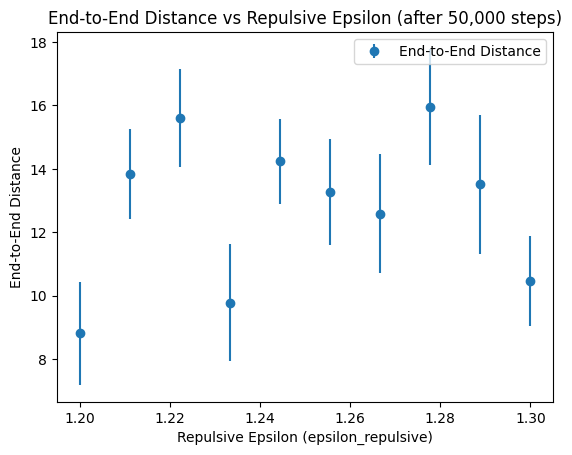

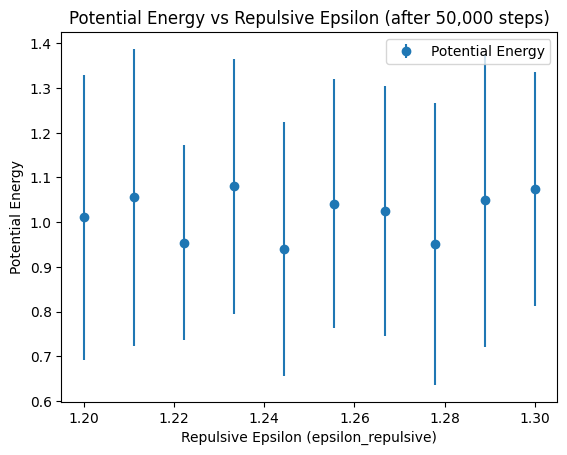

In [5]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from ase import Atoms
from ase.visualize import view

# Set random seed for reproducibility
np.random.seed(42)

# Simulation parameters
dt = 0.01  # Time step
total_steps = 60000  # Number of steps (20,000 in total)
box_size = 100.0  # Size of the cubic box
mass = 1.0  # Particle mass
r0 = 1.0  # Equilibrium bond length
target_temperature = 0.1  # Target temperature (fixed)
rescale_interval = 100  # Steps between velocity rescaling
n_particles = 20  # Number of particles
epsilon_attractive = 0.5  # Depth of attractive LJ potential
sigma = 1.0  # LJ potential parameter
cutoff = 1e-6 * sigma  # Reduce cutoff to limit attraction range
k_B = 1.0  # Boltzmann constant
k = 1.0  # Spring constant (fixed)

# Initialize Positions and Velocities
def initialize_chain(n_particles, box_size, r0):
    positions = np.zeros((n_particles, 3))
    current_position = np.array([box_size / 2, box_size / 2, box_size / 2])
    positions[0] = current_position
    for i in range(1, n_particles):
        direction = np.random.randn(3)
        direction /= np.linalg.norm(direction)
        next_position = current_position + r0 * direction
        positions[i] = next_position % box_size
        current_position = positions[i]
    return positions

def initialize_velocities(n_particles, target_temperature, mass):
    velocities = np.random.normal(0, np.sqrt(k_B * target_temperature / mass), (n_particles, 3))
    velocities -= np.mean(velocities, axis=0)  # Remove net momentum
    return velocities

# Apply Periodic Boundary Conditions
def apply_pbc(position, box_size):
    return position % box_size

# Compute Forces
def minimum_image(displacement, box_size):
    return displacement - box_size * np.round(displacement / box_size)

# Harmonic Forces
def compute_harmonic_forces(positions, k, r0, box_size):
    forces = np.zeros_like(positions)
    for i in range(n_particles - 1):
        displacement = positions[i + 1] - positions[i]
        displacement = minimum_image(displacement, box_size)
        distance = np.linalg.norm(displacement)
        force_magnitude = -k * (distance - r0)
        force = force_magnitude * (displacement / distance)
        forces[i] -= force
        forces[i + 1] += force
    return forces

# Lennard-Jones Forces
def compute_lennard_jones_forces(positions, epsilon, sigma, box_size, interaction_type):
    forces = np.zeros_like(positions)
    for i in range(n_particles - 1):
        for j in range(i + 1, n_particles):
            if interaction_type == 'repulsive' and abs(i - j) == 2:
                epsilon_value = epsilon
            elif interaction_type == 'attractive' and abs(i - j) > 2:
                epsilon_value = epsilon_attractive
            else:
                continue
            displacement = positions[j] - positions[i]
            displacement = minimum_image(displacement, box_size)
            distance = np.linalg.norm(displacement)
            if distance < cutoff:
                force_magnitude = 24 * epsilon_value * ((sigma / distance)**12 - 0.5 * (sigma / distance)**6) / distance
                force = force_magnitude * (displacement / distance)
                forces[i] -= force
                forces[j] += force
    return forces

# Velocity Verlet Integration
def velocity_verlet(positions, velocities, forces, dt, mass, epsilon_repulsive):
    velocities += 0.5 * forces / mass * dt
    positions += velocities * dt
    positions = apply_pbc(positions, box_size)
    new_forces = compute_harmonic_forces(positions, k, r0, box_size) + \
                 compute_lennard_jones_forces(positions, epsilon_repulsive, sigma, box_size, 'repulsive') + \
                 compute_lennard_jones_forces(positions, epsilon_attractive, sigma, box_size, 'attractive')
    velocities += 0.5 * new_forces / mass * dt
    return positions, velocities, new_forces

# Velocity Rescaling Thermostat
def rescale_velocities(velocities, target_temperature, mass):
    kinetic_energy = 0.5 * mass * np.sum(np.linalg.norm(velocities, axis=1)**2)
    current_temperature = (2 / 3) * kinetic_energy / (n_particles * k_B)
    scaling_factor = np.sqrt(target_temperature / current_temperature)
    velocities *= scaling_factor
    return velocities

# Analysis Functions
def calculate_radius_of_gyration(positions):
    center_of_mass = np.mean(positions, axis=0)
    Rg_squared = np.mean(np.sum((positions - center_of_mass)**2, axis=1))
    Rg = np.sqrt(Rg_squared)
    return Rg

def calculate_end_to_end_distance(positions):
    Ree = np.linalg.norm(positions[-1] - positions[0])
    return Ree

# Arrays to store results for different epsilon_repulsive values
epsilon_repulsive_values = np.linspace(1.2, 1.3, 10)
mean_Rg_values = []
std_Rg_values = []
mean_Ree_values = []
std_Ree_values = []
mean_potential_energies = []
std_potential_energies = []

for epsilon_repulsive in epsilon_repulsive_values:
    # Re-initialize positions and velocities for each epsilon_repulsive value
    positions = initialize_chain(n_particles, box_size, r0)
    velocities = initialize_velocities(n_particles, target_temperature, mass)
    forces = compute_harmonic_forces(positions, k, r0, box_size) + \
             compute_lennard_jones_forces(positions, epsilon_repulsive, sigma, box_size, 'repulsive') + \
             compute_lennard_jones_forces(positions, epsilon_attractive, sigma, box_size, 'attractive')

    # Arrays to store properties during each step after 50,000 steps
    Rg_values = []
    Ree_values = []
    potential_energies = []

    # Run simulation loop
    for step in range(total_steps):
        positions, velocities, forces = velocity_verlet(positions, velocities, forces, dt, mass, epsilon_repulsive)
        if step % rescale_interval == 0:
            velocities = rescale_velocities(velocities, target_temperature, mass)

        # Store values only after step 50,000
        if step >= 50000:
            # Compute properties for this step
            Rg = calculate_radius_of_gyration(positions)
            Ree = calculate_end_to_end_distance(positions)

            # Calculate potential energy
            E_harmonic = 0.0
            for i in range(n_particles - 1):
                displacement = positions[i + 1] - positions[i]
                displacement = minimum_image(displacement, box_size)
                distance = np.linalg.norm(displacement)
                E_harmonic += 0.5 * k * (distance - r0)**2

            E_LJ = 0.0
            for i in range(n_particles - 1):
                for j in range(i + 1, n_particles):
                    displacement = positions[j] - positions[i]
                    displacement = minimum_image(displacement, box_size)
                    distance = np.linalg.norm(displacement)
                    if distance < cutoff:
                        if abs(i - j) == 2:
                            epsilon_value = epsilon_repulsive
                        elif abs(i - j) > 2:
                            epsilon_value = epsilon_attractive
                        else:
                            continue
                        E_LJ += 4 * epsilon_value * ((sigma / distance)**12 - (sigma / distance)**6)

            potential_energy = E_harmonic + E_LJ

            # Store values
            Rg_values.append(Rg)
            Ree_values.append(Ree)
            potential_energies.append(potential_energy)

    # Convert lists to NumPy arrays for easier calculations
    Rg_values = np.array(Rg_values)
    Ree_values = np.array(Ree_values)
    potential_energies = np.array(potential_energies)

    # Calculate mean and standard deviation for each property after step 10,000
    mean_Rg_values.append(np.mean(Rg_values))
    std_Rg_values.append(np.std(Rg_values))

    mean_Ree_values.append(np.mean(Ree_values))
    std_Ree_values.append(np.std(Ree_values))

    mean_potential_energies.append(np.mean(potential_energies))
    std_potential_energies.append(np.std(potential_energies))

# Plotting the results with error bars
plt.figure()
plt.errorbar(epsilon_repulsive_values, mean_Rg_values, yerr=std_Rg_values, fmt='o', label='Radius of Gyration')
plt.xlabel('Repulsive Epsilon (epsilon_repulsive)')
plt.ylabel('Radius of Gyration')
plt.title('Radius of Gyration vs Repulsive Epsilon (after 50,000 steps)')
plt.legend()
plt.show()

plt.figure()
plt.errorbar(epsilon_repulsive_values, mean_Ree_values, yerr=std_Ree_values, fmt='o', label='End-to-End Distance')
plt.xlabel('Repulsive Epsilon (epsilon_repulsive)')
plt.ylabel('End-to-End Distance')
plt.title('End-to-End Distance vs Repulsive Epsilon (after 50,000 steps)')
plt.legend()
plt.show()

plt.figure()
plt.errorbar(epsilon_repulsive_values, mean_potential_energies, yerr=std_potential_energies, fmt='o', label='Potential Energy')
plt.xlabel('Repulsive Epsilon (epsilon_repulsive)')
plt.ylabel('Potential Energy')
plt.title('Potential Energy vs Repulsive Epsilon (after 50,000 steps)')
plt.legend()
plt.show()


In [7]:
# Print results for Radius of Gyration
print("Repulsive Epsilon vs Radius of Gyration")
print(f"{'Epsilon_Repulsive':>18} {'Mean Rg':>10} {'Std Rg':>10}")
for epsilon, mean_Rg, std_Rg in zip(epsilon_repulsive_values, mean_Rg_values, std_Rg_values):
    print(f"{epsilon:18.4f} {mean_Rg:10.4f} {std_Rg:10.4f}")

print("\nRepulsive Epsilon vs End-to-End Distance")
print(f"{'Epsilon_Repulsive':>18} {'Mean Ree':>10} {'Std Ree':>10}")
for epsilon, mean_Ree, std_Ree in zip(epsilon_repulsive_values, mean_Ree_values, std_Ree_values):
    print(f"{epsilon:18.4f} {mean_Ree:10.4f} {std_Ree:10.4f}")

print("\nRepulsive Epsilon vs Potential Energy")
print(f"{'Epsilon_Repulsive':>18} {'Mean PE':>10} {'Std PE':>10}")
for epsilon, mean_PE, std_PE in zip(epsilon_repulsive_values, mean_potential_energies, std_potential_energies):
    print(f"{epsilon:18.4f} {mean_PE:10.4f} {std_PE:10.4f}")


Repulsive Epsilon vs Radius of Gyration
 Epsilon_Repulsive    Mean Rg     Std Rg
            1.2000     3.6788     0.4207
            1.2111     4.9079     0.5022
            1.2222     5.4514     0.2626
            1.2333     3.6315     0.4444
            1.2444     5.0635     0.3191
            1.2556     4.6551     0.5691
            1.2667     4.5070     0.5409
            1.2778     5.4872     0.4287
            1.2889     4.8656     0.5243
            1.3000     3.9633     0.3045

Repulsive Epsilon vs End-to-End Distance
 Epsilon_Repulsive   Mean Ree    Std Ree
            1.2000     8.8119     1.6219
            1.2111    13.8341     1.4126
            1.2222    15.5894     1.5360
            1.2333     9.7717     1.8480
            1.2444    14.2334     1.3361
            1.2556    13.2611     1.6619
            1.2667    12.5789     1.8728
            1.2778    15.9413     1.8360
            1.2889    13.5135     2.1916
            1.3000    10.4598     1.4319

Repulsive Epsil

Trajectories for epsilon_repulsive 1.00 saved to: C:\Users\khh38\Desktop\PhD\Class\comp-prob-solv\Project_2\trajectories_output\trajectories_epsilon_1.00.npy
Trajectories for epsilon_repulsive 1.01 saved to: C:\Users\khh38\Desktop\PhD\Class\comp-prob-solv\Project_2\trajectories_output\trajectories_epsilon_1.01.npy
Trajectories for epsilon_repulsive 1.02 saved to: C:\Users\khh38\Desktop\PhD\Class\comp-prob-solv\Project_2\trajectories_output\trajectories_epsilon_1.02.npy
Trajectories for epsilon_repulsive 1.03 saved to: C:\Users\khh38\Desktop\PhD\Class\comp-prob-solv\Project_2\trajectories_output\trajectories_epsilon_1.03.npy
Trajectories for epsilon_repulsive 1.04 saved to: C:\Users\khh38\Desktop\PhD\Class\comp-prob-solv\Project_2\trajectories_output\trajectories_epsilon_1.04.npy
Trajectories for epsilon_repulsive 1.06 saved to: C:\Users\khh38\Desktop\PhD\Class\comp-prob-solv\Project_2\trajectories_output\trajectories_epsilon_1.06.npy
Trajectories for epsilon_repulsive 1.07 saved to: C:

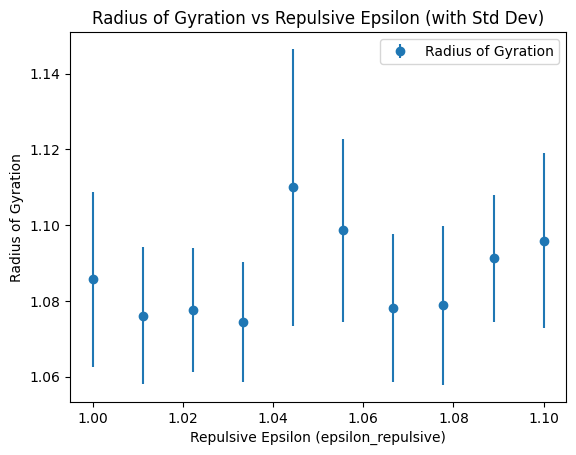

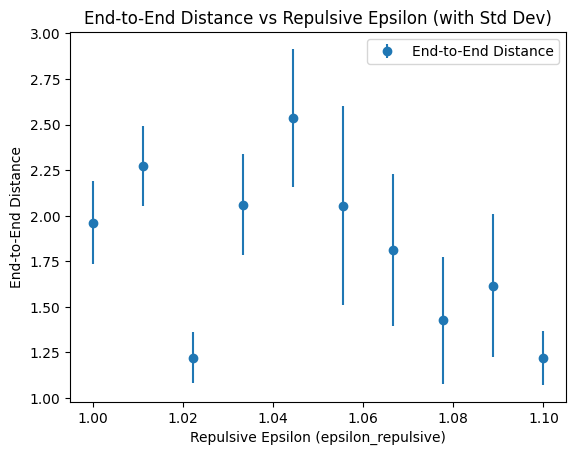

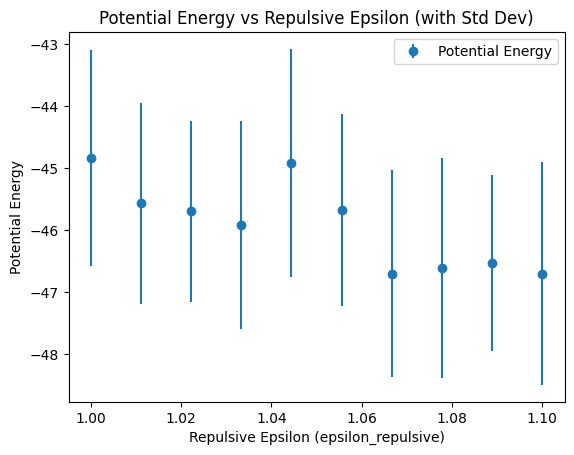

In [8]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from ase import Atoms
from ase.visualize import view
import os

# Set random seed for reproducibility
np.random.seed(42)

# Simulation parameters
dt = 0.01  # Time step
equilibration_steps = 40000  # Equilibration steps
sampling_steps = 10000  # Sampling steps
box_size = 100.0  # Size of the cubic box
k = 1.0  # Spring constant
mass = 1.0  # Particle mass
r0 = 1.0  # Equilibrium bond length
rescale_interval = 100  # Steps between velocity rescaling
n_particles = 20  # Number of particles
epsilon_attractive = 0.5  # Depth of attractive LJ potential
sigma = 1.0  # LJ potential parameter
cutoff = 1e-6 * sigma  # Reduce cutoff to limit attraction range
k_B = 1.0  # Boltzmann constant
target_temperature = 0.1  # Target temperature

# Directory to store trajectories
output_dir = r"C:\Users\khh38\Desktop\PhD\Class\comp-prob-solv\Project_2\trajectories_output"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Initialize Positions and Velocities with ASE Atoms
def initialize_chain_ase(n_particles, box_size, r0):
    """Initialize polymer chain positions with ASE."""
    positions = np.zeros((n_particles, 3))
    current_position = np.array([box_size / 2, box_size / 2, box_size / 2])
    positions[0] = current_position
    for i in range(1, n_particles):
        direction = np.random.randn(3)
        direction /= np.linalg.norm(direction)
        next_position = current_position + r0 * direction
        positions[i] = next_position % box_size
        current_position = positions[i]

    # Create ASE Atoms object
    polymer_chain = Atoms(positions=positions, symbols='C' * n_particles, cell=[box_size, box_size, box_size], pbc=True)
    return polymer_chain

def initialize_velocities(n_particles, target_temperature, mass):
    velocities = np.random.normal(0, np.sqrt(k_B * target_temperature / mass), (n_particles, 3))
    velocities -= np.mean(velocities, axis=0)  # Remove net momentum
    return velocities

# Apply Periodic Boundary Conditions
def apply_pbc(position, box_size):
    return position % box_size

# Compute Forces
def minimum_image(displacement, box_size):
    return displacement - box_size * np.round(displacement / box_size)

# Harmonic Forces
def compute_harmonic_forces(positions, k, r0, box_size):
    forces = np.zeros_like(positions)
    for i in range(len(positions) - 1):
        displacement = positions[i + 1] - positions[i]
        displacement = minimum_image(displacement, box_size)
        distance = np.linalg.norm(displacement)
        if distance != 0:
            force_magnitude = -k * (distance - r0)
            force = force_magnitude * (displacement / distance)
            forces[i] -= force
            forces[i + 1] += force
    return forces

# Lennard-Jones Forces
def compute_lennard_jones_forces(positions, box_size, epsilon_repulsive):
    forces = np.zeros_like(positions)
    for i in range(len(positions) - 1):
        for j in range(i + 1, len(positions)):
            displacement = positions[j] - positions[i]
            displacement = minimum_image(displacement, box_size)
            distance = np.linalg.norm(displacement)
            if distance < cutoff or distance == 0:
                continue  # Ignore interactions beyond the cutoff or zero distance
            if abs(i - j) == 2:
                epsilon_value = epsilon_repulsive
            elif abs(i - j) > 2:
                epsilon_value = epsilon_attractive
            else:
                continue
            force_magnitude = 24 * epsilon_value * ((sigma / distance)**12 - 0.5 * (sigma / distance)**6) / distance
            force = force_magnitude * (displacement / distance)
            forces[i] -= force
            forces[j] += force
    return forces

# Velocity Verlet Integration
def velocity_verlet(positions, velocities, forces, dt, mass, box_size, epsilon_repulsive):
    velocities += 0.5 * forces / mass * dt
    positions += velocities * dt
    positions = apply_pbc(positions, box_size)
    new_forces = compute_harmonic_forces(positions, k, r0, box_size) + compute_lennard_jones_forces(positions, box_size, epsilon_repulsive)
    velocities += 0.5 * new_forces / mass * dt
    return positions, velocities, new_forces

# Velocity Rescaling Thermostat
def rescale_velocities(velocities, target_temperature, mass):
    kinetic_energy = 0.5 * mass * np.sum(np.linalg.norm(velocities, axis=1)**2)
    current_temperature = (2 / 3) * kinetic_energy / (len(velocities) * k_B)
    scaling_factor = np.sqrt(target_temperature / current_temperature)
    velocities *= scaling_factor
    return velocities

# Analysis Functions
def calculate_radius_of_gyration(positions):
    center_of_mass = np.mean(positions, axis=0)
    Rg_squared = np.mean(np.sum((positions - center_of_mass)**2, axis=1))
    Rg = np.sqrt(Rg_squared)
    return Rg

def calculate_end_to_end_distance(positions):
    Ree = np.linalg.norm(positions[-1] - positions[0])
    return Ree

# Epsilon range for the simulation
epsilon_repulsive_values = np.linspace(1.0, 1.1, 10)

# Arrays to store results for different epsilon values
mean_Rg_values = []
std_Rg_values = []
mean_Ree_values = []
std_Ree_values = []
mean_potential_energies = []
std_potential_energies = []

# Loop over each epsilon_repulsive
for epsilon_repulsive in epsilon_repulsive_values:
    # Initialize positions and velocities with ASE
    polymer_chain = initialize_chain_ase(n_particles, box_size, r0)
    positions = polymer_chain.get_positions()
    velocities = initialize_velocities(n_particles, target_temperature, mass)
    forces = compute_harmonic_forces(positions, k, r0, box_size) + compute_lennard_jones_forces(positions, box_size, epsilon_repulsive)

    # Equilibration phase
    for step in range(equilibration_steps):
        positions, velocities, forces = velocity_verlet(positions, velocities, forces, dt, mass, box_size, epsilon_repulsive)
        polymer_chain.set_positions(positions)
        if step % rescale_interval == 0:
            velocities = rescale_velocities(velocities, target_temperature, mass)

    # Sampling phase
    Rg_values = []
    Ree_values = []
    potential_energies = []
    trajectories = []

    for step in range(sampling_steps):
        positions, velocities, forces = velocity_verlet(positions, velocities, forces, dt, mass, box_size, epsilon_repulsive)
        polymer_chain.set_positions(positions)  # Update ASE positions
        if step % rescale_interval == 0:
            velocities = rescale_velocities(velocities, target_temperature, mass)

        # Compute properties
        Rg = calculate_radius_of_gyration(positions)
        Ree = calculate_end_to_end_distance(positions)

        # Calculate potential energy
        E_harmonic = 0.0
        for i in range(n_particles - 1):
            displacement = positions[i + 1] - positions[i]
            displacement = minimum_image(displacement, box_size)
            distance = np.linalg.norm(displacement)
            E_harmonic += 0.5 * k * (distance - r0)**2

        E_LJ = 0.0
        for i in range(len(positions) - 1):
            for j in range(i + 1, len(positions)):
                displacement = positions[j] - positions[i]
                displacement = minimum_image(displacement, box_size)
                distance = np.linalg.norm(displacement)
                if distance < cutoff or distance == 0:
                    continue  # Ignore interactions beyond the cutoff or zero distance
                if abs(i - j) == 2:
                    epsilon_value = epsilon_repulsive
                elif abs(i - j) > 2:
                    epsilon_value = epsilon_attractive
                else:
                    continue
                E_LJ += 4 * epsilon_value * ((sigma / distance)**12 - (sigma / distance)**6)

        potential_energy = E_harmonic + E_LJ

        # Store results
        Rg_values.append(Rg)
        Ree_values.append(Ree)
        potential_energies.append(potential_energy)
        trajectories.append(positions.copy())

    # Convert lists to NumPy arrays
    Rg_values = np.array(Rg_values)
    Ree_values = np.array(Ree_values)
    potential_energies = np.array(potential_energies)
    trajectories = np.array(trajectories)

    # Save the trajectory data for the current epsilon value
    trajectory_file_path = os.path.join(output_dir, f"trajectories_epsilon_{epsilon_repulsive:.2f}.npy")
    np.save(trajectory_file_path, trajectories)
    print(f"Trajectories for epsilon_repulsive {epsilon_repulsive:.2f} saved to: {trajectory_file_path}")

    # Calculate mean and standard deviation for the current epsilon value
    mean_Rg_values.append(np.mean(Rg_values))
    std_Rg_values.append(np.std(Rg_values))

    mean_Ree_values.append(np.mean(Ree_values))
    std_Ree_values.append(np.std(Ree_values))

    mean_potential_energies.append(np.mean(potential_energies))
    std_potential_energies.append(np.std(potential_energies))

# Plotting the results with standard deviation
plt.figure()
plt.errorbar(epsilon_repulsive_values, mean_Rg_values, yerr=std_Rg_values, fmt='o', label='Radius of Gyration')
plt.xlabel('Repulsive Epsilon (epsilon_repulsive)')
plt.ylabel('Radius of Gyration')
plt.title('Radius of Gyration vs Repulsive Epsilon (with Std Dev)')
plt.legend()
plt.show()

plt.figure()
plt.errorbar(epsilon_repulsive_values, mean_Ree_values, yerr=std_Ree_values, fmt='o', label='End-to-End Distance')
plt.xlabel('Repulsive Epsilon (epsilon_repulsive)')
plt.ylabel('End-to-End Distance')
plt.title('End-to-End Distance vs Repulsive Epsilon (with Std Dev)')
plt.legend()
plt.show()

plt.figure()
plt.errorbar(epsilon_repulsive_values, mean_potential_energies, yerr=std_potential_energies, fmt='o', label='Potential Energy')
plt.xlabel('Repulsive Epsilon (epsilon_repulsive)')
plt.ylabel('Potential Energy')
plt.title('Potential Energy vs Repulsive Epsilon (with Std Dev)')
plt.legend()
plt.show()


In [9]:
# Print results for Radius of Gyration
print("Repulsive Epsilon vs Radius of Gyration")
print(f"{'Epsilon_Repulsive':>18} {'Mean Rg':>10} {'Std Rg':>10}")
for epsilon, mean_Rg, std_Rg in zip(epsilon_repulsive_values, mean_Rg_values, std_Rg_values):
    print(f"{epsilon:18.4f} {mean_Rg:10.4f} {std_Rg:10.4f}")

print("\nRepulsive Epsilon vs End-to-End Distance")
print(f"{'Epsilon_Repulsive':>18} {'Mean Ree':>10} {'Std Ree':>10}")
for epsilon, mean_Ree, std_Ree in zip(epsilon_repulsive_values, mean_Ree_values, std_Ree_values):
    print(f"{epsilon:18.4f} {mean_Ree:10.4f} {std_Ree:10.4f}")

print("\nRepulsive Epsilon vs Potential Energy")
print(f"{'Epsilon_Repulsive':>18} {'Mean PE':>10} {'Std PE':>10}")
for epsilon, mean_PE, std_PE in zip(epsilon_repulsive_values, mean_potential_energies, std_potential_energies):
    print(f"{epsilon:18.4f} {mean_PE:10.4f} {std_PE:10.4f}")


Repulsive Epsilon vs Radius of Gyration
 Epsilon_Repulsive    Mean Rg     Std Rg
            1.0000     1.0857     0.0231
            1.0111     1.0761     0.0180
            1.0222     1.0775     0.0164
            1.0333     1.0743     0.0159
            1.0444     1.1100     0.0366
            1.0556     1.0987     0.0242
            1.0667     1.0782     0.0196
            1.0778     1.0788     0.0210
            1.0889     1.0913     0.0167
            1.1000     1.0959     0.0231

Repulsive Epsilon vs End-to-End Distance
 Epsilon_Repulsive   Mean Ree    Std Ree
            1.0000     1.9623     0.2297
            1.0111     2.2730     0.2173
            1.0222     1.2211     0.1409
            1.0333     2.0604     0.2777
            1.0444     2.5379     0.3782
            1.0556     2.0538     0.5455
            1.0667     1.8109     0.4171
            1.0778     1.4248     0.3489
            1.0889     1.6156     0.3917
            1.1000     1.2206     0.1487

Repulsive Epsil